In [132]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv, dotenv_values
import os
import datetime
import alpaca
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.option import OptionHistoricalDataClient, OptionLatestQuoteRequest
from alpaca.data.historical.stock import StockHistoricalDataClient, StockTradesRequest, StockBarsRequest
from alpaca.trading.client import TradingClient, GetAssetsRequest
from alpaca.trading.requests import GetOptionContractsRequest, LimitOrderRequest, MarketOrderRequest, GetOrdersRequest
from alpaca.trading.enums import AssetStatus, ContractType, OrderSide, OrderType, TimeInForce, QueryOrderStatus

In [133]:
# Load Alpaca API keys
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
paper = True

In [134]:
# Initiate Alpaca clients
trade_client = TradingClient(api_key=alpaca_api_key,secret_key=alpaca_secret_key,paper=paper)

stock_data_client = StockHistoricalDataClient(api_key=alpaca_api_key, secret_key=alpaca_secret_key)

option_data_client = OptionHistoricalDataClient(api_key=alpaca_api_key, secret_key=alpaca_secret_key)

In [135]:
# Set tickers list and time period for request data
tickers = ['VOX','VCR','VDC','VDE','VFH','VHT','VIS','VGT','VAW','VPU','VNQ','VOO']
lookback = 7*365

In [136]:
delta = datetime.timedelta(days=lookback)
start=datetime.datetime.today() - delta
end=datetime.datetime.today()


# Fetch stock data for our two stocks
request_params = StockBarsRequest(
    symbol_or_symbols=[ticker for ticker in tickers] ,
    start=start,
    end=end,
    timeframe=TimeFrame(1,TimeFrameUnit.Day),
    adjustment='all'
)

data = stock_data_client.get_stock_bars(request_params=request_params)
print(data)


data={'VAW': [{   'close': 118.41,
    'high': 119.2,
    'low': 118.15,
    'open': 119.18,
    'symbol': 'VAW',
    'timestamp': datetime.datetime(2018, 7, 27, 4, 0, tzinfo=TzInfo(UTC)),
    'trade_count': 707.0,
    'volume': 104925.0,
    'vwap': 118.67}, {   'close': 118.08,
    'high': 119.17,
    'low': 117.94,
    'open': 118.5,
    'symbol': 'VAW',
    'timestamp': datetime.datetime(2018, 7, 30, 4, 0, tzinfo=TzInfo(UTC)),
    'trade_count': 629.0,
    'volume': 73039.0,
    'vwap': 118.66}, {   'close': 119.07,
    'high': 119.39,
    'low': 118.22,
    'open': 118.36,
    'symbol': 'VAW',
    'timestamp': datetime.datetime(2018, 7, 31, 4, 0, tzinfo=TzInfo(UTC)),
    'trade_count': 582.0,
    'volume': 60052.0,
    'vwap': 118.92}, {   'close': 117.91,
    'high': 119.06,
    'low': 117.65,
    'open': 119.06,
    'symbol': 'VAW',
    'timestamp': datetime.datetime(2018, 8, 1, 4, 0, tzinfo=TzInfo(UTC)),
    'trade_count': 738.0,
    'volume': 67904.0,
    'vwap': 118.26}, {   

In [137]:
dfs = []

for ticker in tickers:
    ticker_data = data[ticker]
    df = pd.DataFrame(
        [(t.close, t.volume, t.timestamp) for t in ticker_data],
        columns=[f'close_{ticker}', f'volume_{ticker}', 'datetime']
    )
    df['date'] = pd.to_datetime(df['datetime']).dt.date
    df = df.drop('datetime', axis=1)
    dfs.append(df.set_index('date'))

# Merge all dataframes on the date index
df_merged = pd.concat(dfs, axis=1).reset_index()

print(df_merged)

            date  close_VOX  volume_VOX  close_VCR  volume_VCR  close_VDC  \
0     2018-07-27      78.98    280766.0     159.45     87525.0     116.33   
1     2018-07-30      78.58    109628.0     158.27     65762.0     116.12   
2     2018-07-31      78.77    110097.0     159.00     84295.0     116.66   
3     2018-08-01      78.56     68464.0     158.16     58536.0     115.51   
4     2018-08-02      79.16    102881.0     159.89     99349.0     116.97   
...          ...        ...         ...        ...         ...        ...   
1752  2025-07-18     170.38    726288.0     370.29     31528.0     218.61   
1753  2025-07-21     172.53    146730.0     371.79     48423.0     218.58   
1754  2025-07-22     172.64    267343.0     376.22     36720.0     220.31   
1755  2025-07-23     173.65    165054.0     378.56     27327.0     220.70   
1756  2025-07-24     174.17    204768.0     371.45     28233.0     219.98   

      volume_VDC  close_VDE  volume_VDE  close_VFH  ...  close_VGT  \
0    

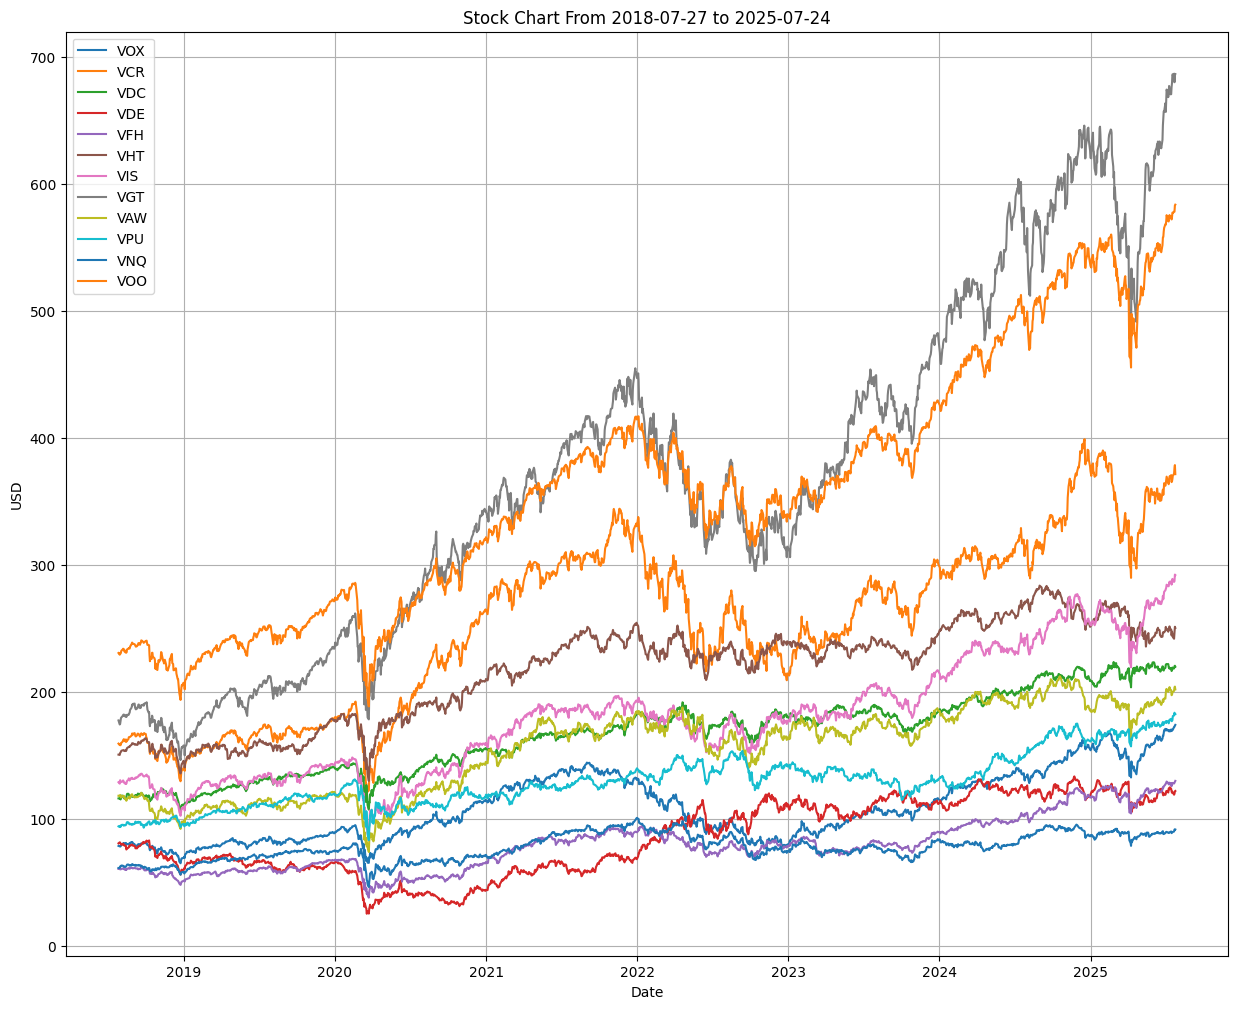

In [138]:
# Plot stock chart
plt.figure(figsize=(15,12))
for ticker in tickers:
    plt.plot(df_merged["date"], df_merged[f'close_{ticker}'], label=ticker)
plt.title(f"Stock Chart From {df_merged['date'][0]} to {df_merged['date'][df.index[-1]]}")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.show()

In [139]:
# Calculate daily return and cumulative return
for ticker in tickers:
    df_merged[f'daily_return_{ticker}'] = df_merged[[f'close_{ticker}']].pct_change().dropna()
    df_merged[f'tot_return_{ticker}'] = (1 + df_merged[[f'close_{ticker}']].pct_change()).cumprod()


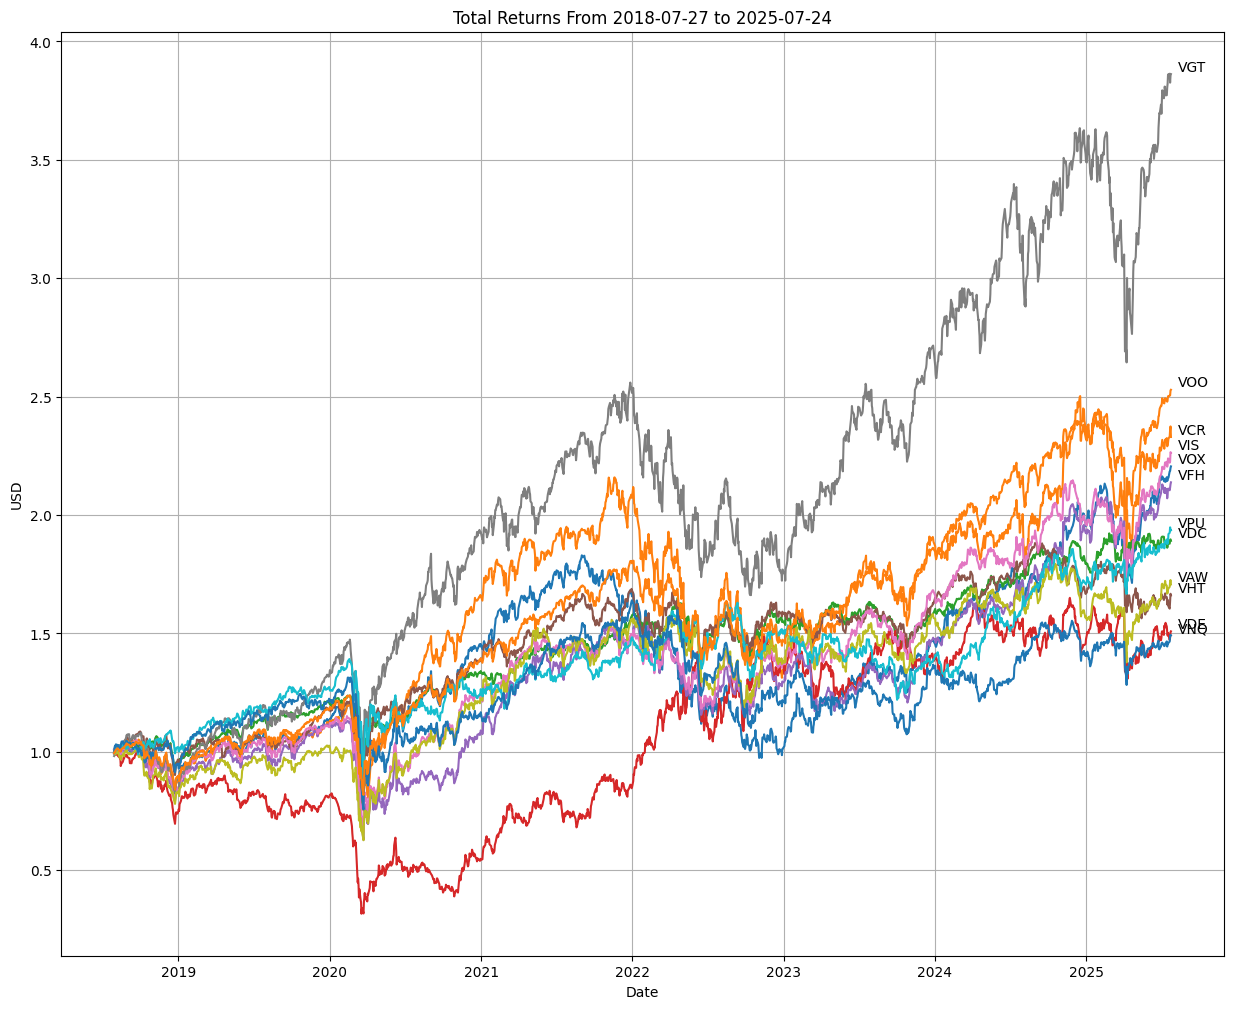

In [140]:
# Plot stock chart
fig, ax = plt.subplots(figsize=(15,12))
for ticker in tickers:
    ax.plot(df_merged["date"], df_merged[f'tot_return_{ticker}'], label=ticker)
    ax.annotate(ticker, xy=(df_merged["date"][df.index[-1]], df_merged[f'tot_return_{ticker}'][df.index[-1]]), xytext=(5, 5), textcoords='offset points', ha='left', va='center')
plt.title(f"Total Returns From {df_merged['date'][0]} to {df_merged['date'][df.index[-1]]}")
plt.xlabel("Date")
plt.ylabel("USD")
plt.grid(True)
plt.show()

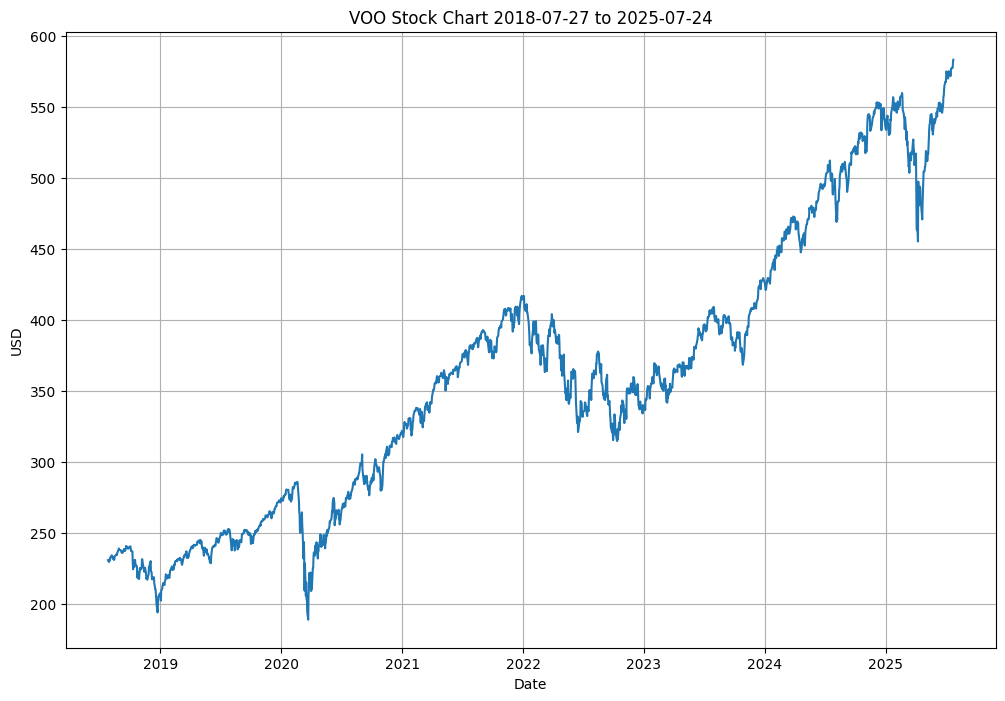

In [141]:
plt.figure(figsize=(12,8))
plt.plot(df_merged['date'],df_merged['close_VOO'])
plt.title(f"VOO Stock Chart {df_merged['date'][0]} to {df_merged['date'][df.index[-1]]}")
plt.xlabel("Date")
plt.ylabel("USD")
plt.grid(True)
plt.show()